# Train a model to predict a color type

In [1]:
# eliminate library warnings
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# set matplotlib outputs/plots to be embeded inline to notebook cells
%matplotlib inline

In [2]:
# read data
df = pd.read_csv('data/warm_cold_colors.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 4 columns):
r          136 non-null int64
g          136 non-null int64
b          136 non-null int64
is_warm    136 non-null int64
dtypes: int64(4)
memory usage: 4.3 KB


It is very usefull to downcast the data types from the default ones to reduce the memory consumption and consequentially to speed-up computation process

In [5]:
# cast the data types
df[['r', 'g', 'b']] = df[['r', 'g', 'b']].astype(np.int16)
df['is_warm'] = df['is_warm'].astype(np.int8)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 4 columns):
r          136 non-null int16
g          136 non-null int16
b          136 non-null int16
is_warm    136 non-null int8
dtypes: int16(3), int8(1)
memory usage: 1.0 KB


In our case, we reduced the memory consumtion by the factor of **4**(!) even though it wasn't critical since we have a tiny data set, however in case of 1M+ records, it is a reasonable first step prior to building a machine learning model. In fact, types downcasting is used for <a href="https://www.tensorflow.org/lite" target="_blank">tensorflow lite</a> as a part of the post-training quantization (see details <a href="https://www.tensorflow.org/lite/performance/post_training_quantization" target="_blank">here</a>).

In [7]:
# check the classes distribution skewness
df[['is_warm', 'r']].groupby(['is_warm'])\
                    .count()\
                    .reset_index()

,is_warm,r
0,0,68
1,1,68


### Explorative Data Analysis - EDA

In [8]:
axes_combinations = [('r', 'g'), 
                     ('r', 'b'), 
                     ('g', 'b')]

color_scale = {'Cool': 'blue', 
               'Warm':'red'}

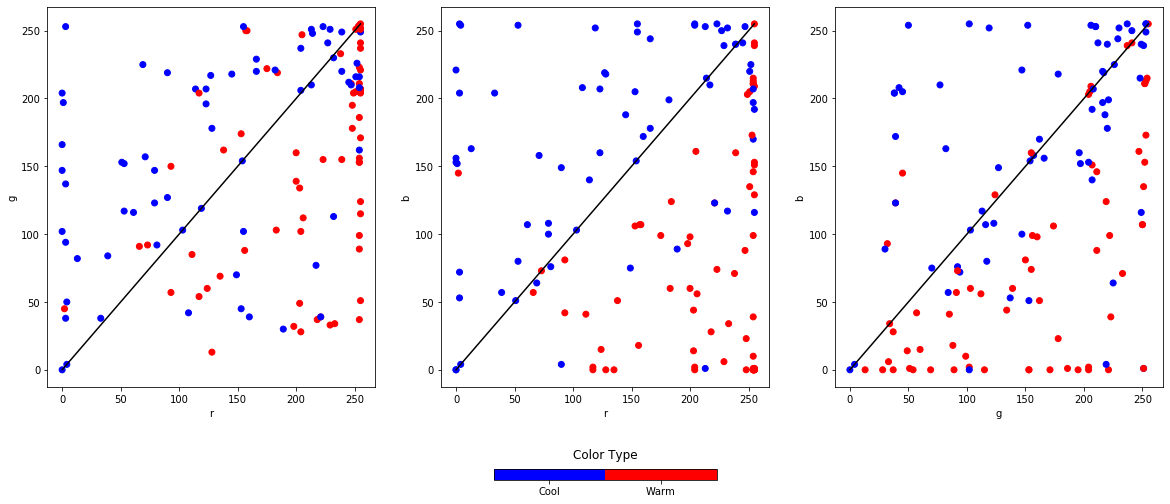

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    x, y = axes_combinations[i]
    
    im = ax.scatter(x=df[x], 
                    y=df[y], 
                    c=df['is_warm'], 
                    cmap=matplotlib.colors.ListedColormap(color_scale.values()))

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.add_line(mlines.Line2D([0,255], [0,255], 
                              color='k'))
    
cb = fig.colorbar(im, 
                  ax=axes.ravel().tolist(), 
                  orientation='horizontal', 
                  shrink=.2) 
cb.ax.set_title('Color Type', pad=10)
cb.set_ticks([.25,.75])
cb.set_ticklabels(list(color_scale.keys()))

plt.show()

## Modelling

### Metrics

How close to reality a model's prediction can be; for a classificaiton problem, <a href="https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62" target="_blank">consufion matrix</a> is usually used.

In [ ]:
%%html
<img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" alt="Precisionrecall.svg" height="480" width="264">
<div style="text-align:center">
By <a href="//commons.wikimedia.org/wiki/User:Walber" title="User:Walber">Walber</a> - <span class="int-own-work" lang="en">Own work</span>, 
<a href="https://creativecommons.org/licenses/by-sa/4.0" title="Creative Commons Attribution-Share Alike 4.0">CC BY-SA 4.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=36926283">Link</a>
</div>

In order to reduce the flase negative and false positive rate, <em><strong>F1 score</strong></em> to be used as the model validation metric:

<div style="text-align:center">
    <font size="5">
        $F_{1} = \frac{2}{\frac{1}{Recall} + \frac{1}{Precision}}$
    </font>
<div style="text-align:center">    

<div style="text-align:center">
    <font size="5">
    $Recall = \frac{TP}{TP+FN}$
    </font>
</div>

describes what fraction of all true "positive" points did a model predict correctly

<div style="text-align:center">
    <font size="5">
        $Precision = \frac{TP}{TP+FP}$
    </font>
</div>

descibes what fraction of all predicted "Positive" points did a model predict correctly

Another widely <s>used</s> abused metric, <strong><em>accuracy</em></strong>:
<div style="text-align:center">
<font size="5">
    $Accuracy = \frac{TP+TN}{TP+FP+TN+FN}$
</font>
</div>

In [47]:
def eval_metrics(y_true: np.array, 
                 y_pred: np.array) -> dict:
    """
    Function to calculate classification metrics
    
        Args:
            y_true: real labels
            y_pred: predicitons
    
        Returs:

            dict with the keys:
                confusion_matrix - confusion matrix
                accuracy = (TP+TN)/(TP+TN+FP+FN)
                precision = TP/(TP+FP)
                recall = TP/(TP+FN)
                f1_score = 2/(1/recall+1/precision)    
    """
    
    assert len(y_true) != 0, "Empty array, please check input"
    
    true_positives = np.where(y_true==1)[0]    
    TP = sum(y_pred[true_positives]==1)
    FN = sum(y_pred[true_positives]==0)
    
    true_negatives = np.where(y_true==0)[0]
    FP = sum(y_pred[true_negatives]==1)
    TN = sum(y_pred[true_negatives]==0)
    
    accuracy = (TP + TN) / len(y_true)
    
    recall = precision = f1_score = None
    
    if FN > 0 or TP > 0:
        recall = float(TP / (TP + FN))
        
    if FP > 0 or TP > 0:
        precision = float(TP / (TP + FP))

    if recall and precision:
        f1_score = 2/(1/recall+1/precision)    
        
    return {
        "confusion_matrix": 
            {
                "TP": TP, "FP": FP, 
                "FN": FN, "TN": TN
            },
            "accuracy": accuracy,
            "recall": recall,
            "precision": precision,
            "f1_score": f1_score
           } 

### Baseline

#### As a baseline, we can set the condition:

```javascript
if r > g > b:
    color_type = 'Warm'
else:
    color_type = 'Cool'
```

In [75]:
class model_baseline:
    """ Baseline model """
    
    import pandas as pd
    
    def __init__(self):
        pass
    
    @classmethod
    def _rule(cls, row: pd.DataFrame) -> int:
        """ Model rule
        
            Args:
                Row: pd.DataFrame row

            Return:
                int
        """

        if row['r'] > row['g'] > row['b']:
            return 1

        return 0

    
    def predict(cls, X: pd.DataFrame) -> pd.core.series.Series:
        """ Function to run a base line prediction

            Args:
                X: input data

            Returns:
                array
        """
    
        return X.apply(lambda row: cls._rule(row), axis=1)

In [80]:
# baseline model
model_v1 = model_baseline()
y_predict_baseline = model_v1.predict(df[['r', 'g', 'b']])

# baseline model evaluation
eval_metrics(df['is_warm'], y_predict_baseline)

{'confusion_matrix': {'TP': 43, 'FP': 5, 'FN': 25, 'TN': 63},
 'accuracy': 0.7794117647058824,
 'recall': 0.6323529411764706,
 'precision': 0.8958333333333334,
 'f1_score': 0.7413793103448275}

So without any machine learning, we were managed to get the F1 score of <strong>0.74</strong> :)

Let's assess out "model" using a random data point:

In [ ]:
# test point -> a color of the "Cool" type/class 0

test_point = pd.DataFrame({'r': [8], 'g': [103], 'b': [203]})

In [ ]:
model_v1.predict(test_point).squeeze()

Let's deploy the baseline model as a POC

#### We can improve our ML service by improving our model's accuracy

### Data preparesion

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
seed = 2019

In [ ]:
df = df.sample(frac=1, random_state=seed)\
       .reset_index(drop=True)

In [ ]:
scale = MinMaxScaler()

In [ ]:
X = df.drop('is_warm', axis=1)

In [ ]:
X_scaled = scale.fit_transform(X)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, df['is_warm'], 
                                                    test_size=0.2, 
                                                    random_state=seed)

### XGBoost

In [ ]:
from xgboost import XGBClassifier as xgb_class 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('is_warm', axis=1), df['is_warm'], 
                                                    test_size=0.2, 
                                                    random_state=seed)

In [ ]:
params = {
    "objective": 'binary:logistic',
    "learning_rate": 0.5, 
    "n_estimators": 100, 
    "max_depth": 3,
    "n_jobs": 4,
    "silent": False, 
    "subsample": 0.8,
    "random_state": seed
}

model_v2 = xgb_class(**params)

model_v2.fit(x_train, y_train, verbose=True)

In [ ]:
y_predict_xgb = model_v2.predict(df.drop('is_warm', axis=1))

In [ ]:
eval_metrics(df['is_warm'], y_predict_xgb)

In [ ]:
# point test

model_v2.predict(test_point).squeeze()

<strong>0.97</strong> is quite an improvement, so let's dump the model and re-deploy the service

In [ ]:
import pickle

def save_object(obj, filename):
    """
    Function to save/pickle python object

        Args:
            filename: str path to pickle file
    """

    with open(filename, 'wb') as output:
        pickle.dump(obj, output, -1)

In [ ]:
save_object(model_v2, '../model/v2/model_v2.sav')